# Evaluate likelihood ratio

In [11]:
import sys, os
import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2

## Settings

In [12]:
filenames = [
    "carl_fix",
    "alices_fix",
    "carl_fix_log",
    "alices_fix_log",
    "carl_mass",
    "alices_mass",
    "carl_mass_log",
    "alices_mass_log",
    "carl_mass_pre",
    "alices_mass_pre",
    "carl_align",
    "alices_align",
    "carl_align_log",
    "alices_align_log",
    "carl_align_pre",
    "alices_align_pre",
    "carl_full",
    "alices_full",
    "carl_full_log",
    "alices_full_log",
    "carl_full_pre",
    "alices_full_pre",
    "carl_full_aux",
    "alices_full_aux",
    "carl_full_aux_log",
    "alices_full_aux_log",
]
settings = ["fix"] * 4 + ["mass"] * 6 + ["align"] * 4 + ["full"] * 10
labels = [
    "Fix: CARL",
    "Fix: ALICES",
    "Fix: CARL-log",
    "Fix: ALICES-log",
    "Mass: CARL",
    "Mass: ALICES",
    "Mass: CARL-log",
    "Mass: ALICES-log",
    "Mass: CARL-pre",
    "Mass: ALICES-pre",
    "Align: CARL",
    "Align: ALICES",
    "Align: CARL-log",
    "Align: ALICES-log",
    "Align: CARL-pre",
    "Align: ALICES-pre",
    "Full: CARL",
    "Full: ALICES",
    "Full: CARL-log",
    "Full: ALICES-log",
    "Full: CARL-pre",
    "Full: ALICES-pre",
    "Full: CARL-aux",
    "Full: ALICES-aux",
    "Full: CARL-aux-log",
    "Full: ALICES-aux-log",
]

nmethods = len(filenames)
ncols = 3
nrows = (nmethods - 1) // ncols + 1

In [13]:
show_summary = [1, 9, 15, 21]
labels_summary=["fix", "mass", "align", "full"]

nmethods_summary = len(show_summary)
ncols_summary = 2
nrows_summary = (nmethods_summary - 1) // ncols_summary + 1

## Data

In [14]:
llrs = []
llrs_cal = []

for filename in filenames:
    try:
        llrs.append(np.load("../data/results/llr_{}_grid.npy".format(filename)))
    except FileNotFoundError:
        print(filename, "not found")
        llrs.append(np.zeros_like(llrs[0]))
        
    try:
        llrs_cal.append(np.load("../data/results/llr_calibrated_{}_grid.npy".format(filename)))
    except (FileNotFoundError, ValueError):
        print("Calibrated", filename, "not found")
        llrs_cal.append(np.zeros_like(llrs[0]))
        
llrs = np.asarray(llrs)
llrs_cal = np.asarray(llrs_cal)

expected_llr = np.mean(llrs, axis=-1)
expected_llr_cal = np.mean(llrs_cal, axis=-1)


Calibrated carl_fix_log not found
Calibrated alices_fix_log not found
Calibrated carl_mass not found
Calibrated alices_mass not found
Calibrated carl_mass_log not found
Calibrated alices_mass_log not found
Calibrated carl_align not found
Calibrated alices_align not found
Calibrated carl_align_log not found
Calibrated alices_align_log not found
Calibrated carl_full not found
Calibrated alices_full not found
Calibrated carl_full_log not found
Calibrated alices_full_log not found
Calibrated carl_full_aux not found
Calibrated alices_full_aux not found
carl_full_aux_log not found
Calibrated carl_full_aux_log not found
alices_full_aux_log not found
Calibrated alices_full_aux_log not found


## Parameter grids

In [15]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Expected LLR plot

In [16]:
llrmin, llrmax = 0., 10.

n_for_lines = [20]
thresholds = [1. / n * chi2.isf(0.05, df=2) for n in n_for_lines]
contour_ls = ["-", "--", ":"]

llr_cmap = "viridis_r"

thresholds

[0.29957322735539915]

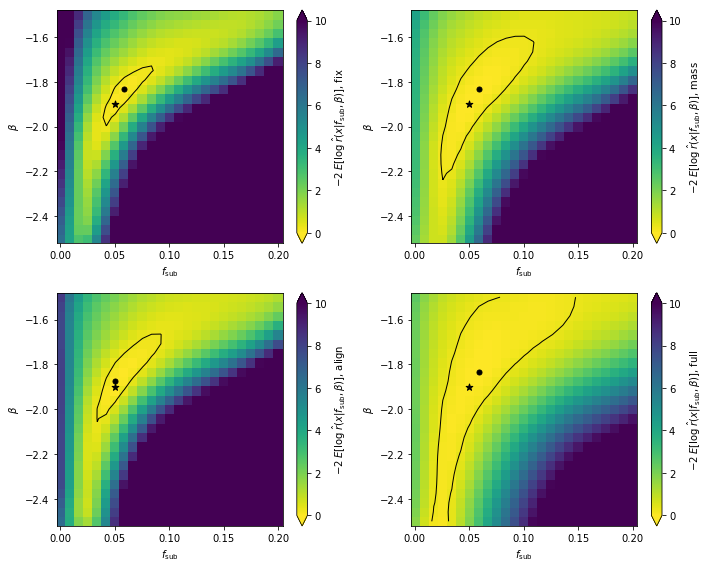

In [17]:
fig = plt.figure(figsize=(5. * ncols_summary, 4. * nrows_summary))
ax_xs = []
ax_rs = []

for k, i in enumerate(show_summary):
    ax = plt.subplot(nrows_summary, ncols_summary, k + 1)

    i_mle = np.argmax(expected_llr[i])
    theta_mle = theta_grid[i_mle]
    z = np.clip(-2. * (expected_llr[i] - expected_llr[i][i_mle]), llrmin, llrmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((resolution, resolution)),
        norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
        cmap=llr_cmap
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    cs = plt.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        z.reshape((resolution, resolution)),
        thresholds,
        colors="black",
        linewidths=1.,
        linestyles=contour_ls,
    )
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=25., color='black', marker='o')

    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; E[\log \;\hat{r}(x | f_{\mathrm{sub}}, \beta)]$, '+ labels_summary[k])
    #plt.clabel(cs)
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/expected_llr_summary.pdf")

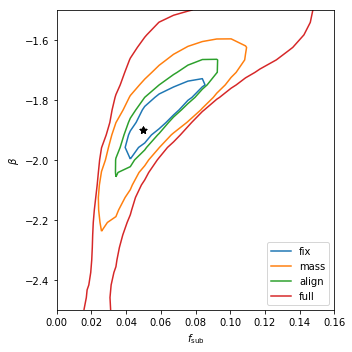

In [18]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

for k, i in enumerate(show_summary):
    i_mle = np.argmax(expected_llr[i])
    theta_mle = theta_grid[i_mle]
    z = np.clip(-2. * (expected_llr[i] - expected_llr[i][i_mle]), llrmin, llrmax)
    cs = plt.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        z.reshape((resolution, resolution)),
        thresholds,
        colors="C{}".format(k),
        linewidths=1.5,
        linestyles=contour_ls
    )
    plt.plot([], [],  color="C{}".format(k), lw=1.5, ls=contour_ls[0], label=labels_summary[k])
    plt.scatter(0.05, -1.9, s=50., color="black", marker='*')
    #plt.scatter(theta_mle[0], theta_mle[1], s=25., color="C{}".format(k), marker='o')

plt.legend(loc="lower right")
plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel(r'$\beta$')
plt.xlim(0.,0.16)
plt.ylim(-2.5,-1.5)  
    
plt.tight_layout()
plt.savefig("../figures/expected_llr_summary2.pdf")

## Calibrated

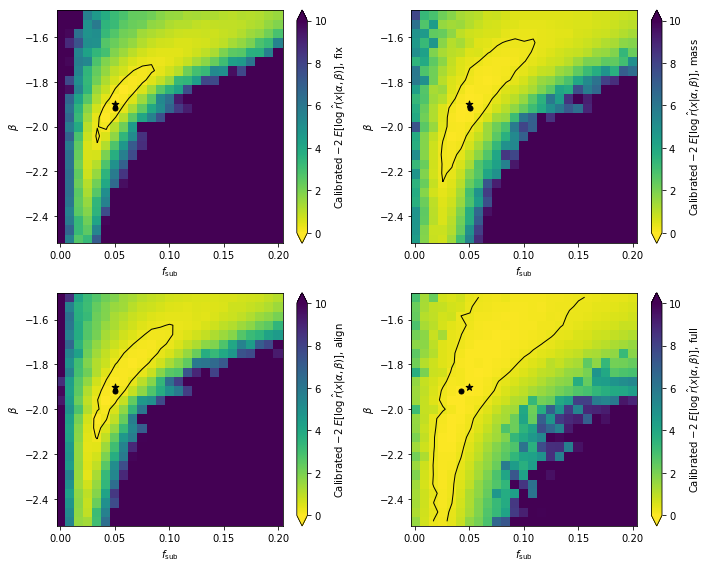

In [19]:
fig = plt.figure(figsize=(5. * ncols_summary, 4. * nrows_summary))
ax_xs = []
ax_rs = []

for k, i in enumerate(show_summary):
    ax = plt.subplot(nrows_summary, ncols_summary, k + 1)

    i_mle = np.argmax(expected_llr_cal[i])
    theta_mle = theta_grid[i_mle]
    z = np.clip(-2. * (expected_llr_cal[i] - expected_llr_cal[i][i_mle]), llrmin, llrmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((resolution, resolution)),
        norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
        cmap=llr_cmap
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    cs = plt.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        z.reshape((resolution, resolution)),
        thresholds,
        colors="black",
        linewidths=1.,
        linestyles=contour_ls,
    )
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=25., color='black', marker='o')

    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'Calibrated $-2\; E[\log \;\hat{r}(x | \alpha, \beta)]$, '+ labels_summary[k])
    #plt.clabel(cs)
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/expected_llr_calibrated.pdf")

## 1D slice

[350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]


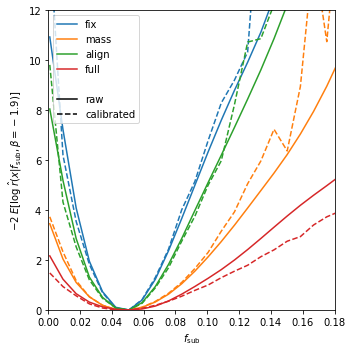

In [20]:
include_calibrated = True
i_beta = 14

print([i_beta*25 + i for i in range(25)])

fig = plt.figure(figsize=(5., 5.))
ax = plt.gca()

for k, i in enumerate(show_summary):
    y = -2. * expected_llr[i]
    y = y.reshape((resolution, resolution))[i_beta, :]
    y = y - np.min(y)
    
    y_cal = -2. * expected_llr_cal[i]
    y_cal = y_cal.reshape((resolution, resolution))[i_beta, :]
    y_cal = y_cal - np.min(y_cal)

    plt.plot(f_sub_1d, y, label=labels_summary[k], ls="-", c="C{}".format(k))
    if include_calibrated:
        plt.plot(f_sub_1d, y_cal, ls="--", c="C{}".format(k))
    
if include_calibrated:
    plt.plot([], [], ls=" ", c="white", label=" ")
    plt.plot([], [], ls="-", c="black", label="raw")
    plt.plot([], [], ls="--", c="black", label="calibrated")
plt.legend()

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel(r'$-2\; E[\log \;\hat{r}(x | f_{\mathrm{sub}}, \beta=-1.9)]$')
plt.xlim(0., 0.18)
plt.ylim(0., 12.)
    
plt.tight_layout()
plt.savefig("../figures/expected_llr_1d.pdf")

## All runs

/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


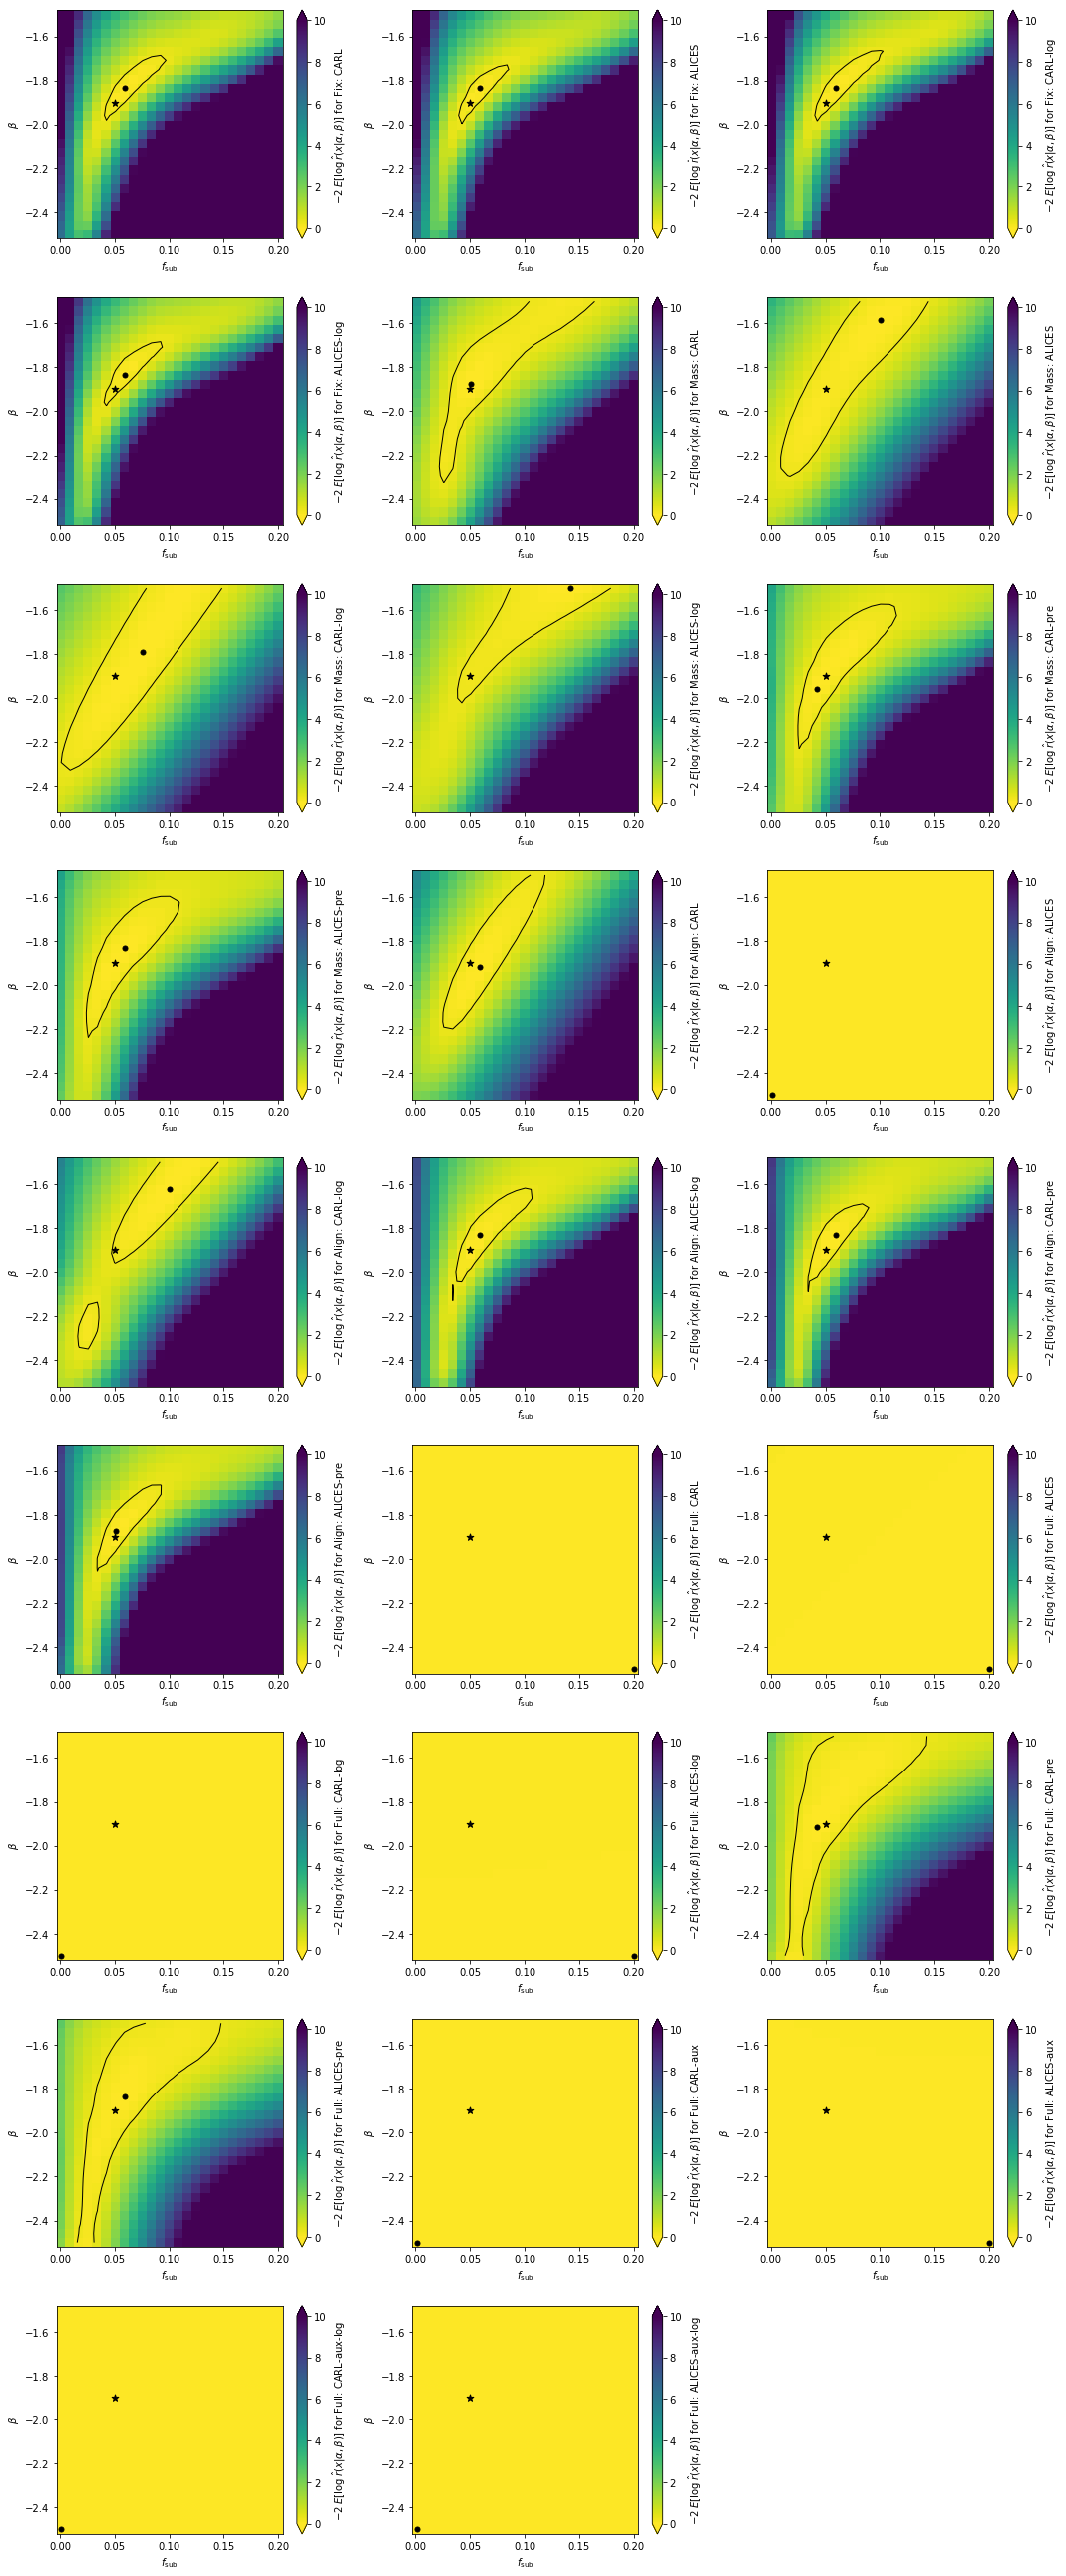

In [11]:
fig = plt.figure(figsize=(5. * ncols, 4. * nrows))
ax_xs = []
ax_rs = []

for k in range(nmethods):
    ax = plt.subplot(nrows, ncols, k + 1)

    i_mle = np.argmax(expected_llr[k])
    theta_mle = theta_grid[i_mle]
    z = np.clip(-2. * (expected_llr[k] - expected_llr[k][i_mle]), llrmin, llrmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((resolution, resolution)),
        norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
        cmap=llr_cmap
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    cs = plt.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        z.reshape((resolution, resolution)),
        thresholds,
        colors="black",
        linewidths=1.,
        linestyles=contour_ls,
    )
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=25., color='black', marker='o')

    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; E[\log \;\hat{r}(x | \alpha, \beta)]$ for '+ labels[k])
    #plt.clabel(cs)
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/expected_llr_all.pdf")